# Empatica Processing and Initial Model Outputs

## Import modules and Authorise Google Drive

In [1]:
# Need to get access to the data in the google drive folder
from google.colab import files
from google.colab import drive
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma

# Import models from sklearn we want to build
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore") # Ignore warnings

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Define data processing functions



*   add_labels: Adds the truth and lie labels to the data based on the timestamps in tags
*   create_signal_data: Extracts the data from the files for all participants for a given signal
    type
*  generate_simple_stats: Creates the simple statistical features


In [0]:
def add_labels(data, tags, silence_label):
    
    '''
    Adds the truth and lie labels to the data based on the timestamps in tags
    
    INPUTS:
        data - dataframe, must a "time" column. This is the data the 
                        labels will be attached to.
        tags - dataframe, must have columns "LT" and "time". This contains the
                        timestamps from the Empatica and the truth/lie labels
        silence_label - int, to denote time not during interaction.
        
    OUTPUTS:
        
        merge_data - dataframe, contains the original data with the labels
    '''
    
    # Change type to int so the matching can happen
    data["time"] = pd.to_numeric(data["time"], downcast='integer')
    
    # Create a list of the timestamps in the session
    first_timestamp = data["time"].iloc[0]
    last_timestamp = data["time"].iloc[len(data)-1]
    all_timestamps = np.arange(first_timestamp, last_timestamp, 1)
    
    # extract the labels and the timestamp information from the tags
    # dataframe
    labels = np.array(tags["LT"])
    timestamps = np.array(tags["time"])
    # Add an final timestamp element to ensure the loop does not 
    # exceed the index count
    timestamps = np.append(timestamps, last_timestamp+1)
    
    # Current label
    current_label = labels[0]
    
    # Empty list to hold the labels and question number for all datapoints
    all_labels = []
    ques_number = []
    
    # Initialise index and question number
    i = 0
    ques = 1
    
    # For all timestamps allocate a label
    for t in all_timestamps:
        
        # If the next timestamp has been reached change the index and
        # the label
        if t == timestamps[i+1]:
            
            i += 1
            current_label = labels[i]
            
            # Check if need to update the question number
            if current_label == 1 or current_label == 0:
                
                ques += 1
            
            
        # If the timestamp is less than the first tag or the label is non
        # then assign dummy value
        if t < timestamps[0]:

            all_labels.append(-2)
            ques_number.append(-2)
            
        elif np.isnan(current_label):
            
            all_labels.append(silence_label)
            ques_number.append(silence_label)
        
        # Otherwise give the current label
        elif t >= timestamps[i] and t < timestamps[i+1]:
            
            all_labels.append(current_label)
            ques_number.append(ques)

    # Create a dataframe with the timestamps and labels
    all_tags = pd.DataFrame({"time": all_timestamps,
                             "tag": all_labels,
                             "ques": ques_number})
        
    # Match the tags to the data
    merge_data = pd.merge(data, all_tags, how='left', on='time')
    
    return merge_data

In [0]:
def create_signal_data(file_paths, mode, normalise = 0, smoothing_frame = 60,  smoothing_poly = 2, filtered = True):
    
    '''
    Extracts the data from the files for all participants for a given signal
    type.
    
    INPUTS:
        file_paths - list, filepaths to the data files
        mode - string, ['EDA', 'HR', 'ACC', 'temp'] denoting the signal type

        filtered - boolean, True returns only the interaction timestamps,
                        False also returns the time not during interaction
        normalise - int, indicate option:
                        0 - none
                        1 - standardise over whole interaction (x-mean)/std
                        2 - normalise (feature scale) over whole interaction (x-min)/(max-min)
                        3 - take off mean from pre-experiment        
        smoothing_frame - int, number of seconds to smooth over
        smoothing_poly - int, degree polynomial to approximate at each stage
                        
    OUTPUT:
        mode_data - dataframe, merged data for all participants for a given 
                    signal type
    '''
    
    # Extract the files which contain the desired modality
    rel_files = [f for f in file_paths if mode in f]
    
    # Create an empty dataframe
    all_columns = ['value', 'time', 'tag', 'ques', 'p_id']
    mode_data = pd.DataFrame(columns = all_columns)
       
    # Read in the pre-prepared participant id matching to the session number
    id_lookup = pd.read_csv('/content/gdrive/My Drive/Affective Computing/Data/Empatica Data/file_lookup.csv')
    
    # For each participant 
    for p, path in enumerate(rel_files):
        
        # Find person_id from list
        p_file = path.split("/")[-2]
        p_id = int(id_lookup["p_id"][id_lookup["file_name"] == p_file])
        
        # Extract the tag file with the timestamps for truth and lies
        tag_file = "/".join(path.split("/")[:-1]) + "/tags_labelled.csv" #.xlsx"

        # Read in the date - ensure the time is an integer in the tag data
        tags = pd.read_csv(tag_file)
        tags["time"] = np.round(tags["time"]).astype('int')
        data = pd.read_csv(path)
        
        # Add the labels for the timestamps and remove silent periods
        tagged_data = add_labels(data, tags, -1)
        
        # sampling frequence
        sampling_rate = tagged_data.groupby(["tag", "ques", "time"]).agg({"value": [np.ma.count]}).reset_index()
        sampling_rate = np.max(sampling_rate["value"])
        
        # Normalise
        if normalise == 1:
            
            mu = np.mean(tagged_data["value"])
            std = np.std(tagged_data["value"])
            
            tagged_data["value"] = (tagged_data["value"] - mu)/std
            
        elif normalise == 2:
            
            tagged_data["value"] = (tagged_data["value"] - np.min(tagged_data["value"]))/(np.max(tagged_data["value"])-np.min(tagged_data["value"]))
            
        elif normalise == 3:
            
            mu = np.mean(tagged_data["value"][tagged_data["tag"] == -2])
            
            tagged_data["value"] = (tagged_data["value"] - mu)
            
        else:
            None
        
        # Smoothing
        points = int(smoothing_frame*sampling_rate)
        
        # The window size needs to be odd
        # ensure with the following if else statement
        if (points%2 == 0) and (smoothing_poly < points):
            
            tagged_data["smooth_value"] = savgol_filter(tagged_data["value"], points+1, smoothing_poly)
            
        elif(points%2 == 1) and (smoothing_poly < points):
            
            tagged_data["smooth_value"] = savgol_filter(tagged_data["value"], points, smoothing_poly)      
            
        else:
            
            print(mode + ": No smoothing as polyorder is greater than window")
                
        
        # If the data is to be filtered complete the following steps
        if filtered == True:
            tagged_data = tagged_data[tagged_data["tag"] != -1]
            tagged_data = tagged_data[tagged_data["tag"] != -2]
            # Get rid of nans
            tagged_data = tagged_data[tagged_data["tag"] == tagged_data["tag"]]
        
        # Include the participant id
        tagged_data["p_id"] = p_id
    
        mode_data = pd.concat([mode_data, tagged_data])   
    
    return mode_data


In [0]:
def generate_simple_stats(data, mode, group =["tag", "ques", "p_id"], smoothed = False):
    
    '''
    Create some simple stats:
        mean, 
        standard deviation, 
        mean of the absolute values of the first difference of the raw signal
        above normalised by mean
        mean of the absolute values of the second difference of the raw signal
        above normalised by mean
        
    for more detail see "Toward machine emotional intelligence: analysis of 
    affective physiological state" (Picard et al 2001)
    
    INPUTS:
        data - dataframe, must contain "tag", "ques", "p_id" and "value"
        mode - string, for the column names
        smoothed - boolean, work with smooth data
    
    OUTPUT:
        agg_data - dataframe, containing the aggregated data and descriptive
                    stats
    
    '''
    
    contains_smooth = False
    
    for col in data.columns.values:
        
        if col == "smooth_value":
            
            contains_smooth = True
            
    
    if smoothed == True and contains_smooth == True:
        
        data['value'] = data['smooth_value']
        
    elif smoothed == False and contains_smooth == True:
        
        # Even if smooth features not used include a smoothed mean if available
        # to augment the vector
        mean_smoothed = data.groupby(group).agg({"smooth_value": [np.nanmean]}).reset_index()
        # Rename all the columns
        mean_smoothed.columns = group + [mode + "_mean_smooth"]
        
    else:
        
        print("No mean smoothing value given")

    # Create extra columns to lag the data by 1 or 2 time steps
    data['value_lagged'] = data.groupby(group)['value'].shift(1)
    data['abs_diff_1'] = abs(data['value_lagged'] - data['value'])
    data['value_lagged2'] = data.groupby(["tag", "ques", "p_id"])['value'].shift(2)
    data['abs_diff_2'] = abs(data['value_lagged2'] - data['value'])
    
    # Find the mean and std of the raw value and the means of the lagged variables
    agg_data = data.groupby(group).agg({"value": [np.nanmean, np.nanstd],
                                                   "abs_diff_1":[np.nanmean],
                                                   "abs_diff_2":[np.nanmean]}).reset_index()
    
    # Rename all the columns
    agg_data.columns = group + [mode + "_mean",  mode + "_std",
                        mode + "_first_diff",  mode + "_second_diff"]
    
    if mode != "temp":
        # Create the normalised variables
        agg_data[mode + "_first_diff_norm"] = agg_data[mode + "_first_diff"]/agg_data[mode + "_std"]
        agg_data[mode + "_second_diff_norm"] = agg_data[mode + "_second_diff"]/agg_data[mode + "_std"]
        
        
    if smoothed == False and contains_smooth == True:
        agg_data = pd.merge(agg_data, mean_smoothed, how = "left", on = group)
    
    return agg_data

In [0]:
# Set directory to reach data folders
os.chdir('/content/gdrive/My Drive/Affective Computing/Data/Empatica Data')

## Gather data files into a list to pre-process in a single batch

In [0]:
#----------------------------------------------------------------------------#
# Extract the data file paths 
#----------------------------------------------------------------------------#

# List all the files and folders in the current directory and remove those which
# are not relevant
p_files = os.listdir()
p_files = [p for p in p_files if not "Python Scripts" in p]
p_files = [p for p in p_files if not "pickle" in p]
p_files = [p for p in p_files if not "file_lookup" in p]

base_path = '/content/gdrive/My Drive/Affective Computing/Data/Empatica Data/'

# To save the data_files
data_files = []

for p in p_files:
  
    file_path = base_path + p
       
    # List the files in the current folder 
    all_files = os.listdir(p)
       
    # Construct the filepaths to the data files
    rel_files = [file_path + "/" + f for f in all_files if "_withtime" in f]
    
    # Add these to the data_files list
    data_files = data_files + rel_files

## Apply transformation  and generate simple statistics for EDA, Temp, HR, BVP

In [7]:
#----------------------------------------------------------------------------#
# Get data and aggregate
#----------------------------------------------------------------------------#

# Data normalisation strategy
# 0 - none
# 1 - standardise over whole interaction (x-mean)/std
# 2 - normalise (feature scale) over whole interaction (x-min)/(max-min)
# 3 - take off mean from pre-experiment
n_strat = 0
# Number of seconds to smooth over - set to 0 to avoid any smoothing
s_frame =0
# Polynomial approx for each window
s_poly = 2

# Extract, label and collate the different physiological signals
eda_data = create_signal_data(data_files, "EDA", normalise = n_strat, 
                              smoothing_frame = s_frame, smoothing_poly = s_poly)

temp_data = create_signal_data(data_files, "temp", normalise = n_strat,  
                               smoothing_frame = s_frame, smoothing_poly = s_poly)

hr_data = create_signal_data(data_files, "HR", normalise = n_strat,  
                             smoothing_frame = s_frame, smoothing_poly = s_poly)

bvp_data = create_signal_data(data_files, "BVP", normalise = n_strat,  
                              smoothing_frame = s_frame, smoothing_poly = s_poly)

# Will always produce the smoothed mean if there are smoothed values otherwise 
# prints out message
use_smooth = False

# produce the six/four basic statistics for each instance
agg_eda = generate_simple_stats(eda_data, "EDA", smoothed = use_smooth)
agg_temp = generate_simple_stats(temp_data, "temp", smoothed = use_smooth)
agg_hr = generate_simple_stats(hr_data, "HR", smoothed = use_smooth)
agg_bvp = generate_simple_stats(bvp_data, "BVP", smoothed = use_smooth)


EDA: No smoothing as polyorder is greater than window
EDA: No smoothing as polyorder is greater than window
EDA: No smoothing as polyorder is greater than window
EDA: No smoothing as polyorder is greater than window
EDA: No smoothing as polyorder is greater than window
EDA: No smoothing as polyorder is greater than window
temp: No smoothing as polyorder is greater than window
temp: No smoothing as polyorder is greater than window
temp: No smoothing as polyorder is greater than window
temp: No smoothing as polyorder is greater than window
temp: No smoothing as polyorder is greater than window
temp: No smoothing as polyorder is greater than window
HR: No smoothing as polyorder is greater than window
HR: No smoothing as polyorder is greater than window
HR: No smoothing as polyorder is greater than window
HR: No smoothing as polyorder is greater than window
HR: No smoothing as polyorder is greater than window
HR: No smoothing as polyorder is greater than window
BVP: No smoothing as polyord

## Left join data together based on the label (tag), person id and question number

In [0]:
# Merge the aggregated data together
merge_data = pd.merge(agg_eda, agg_temp, how='left', on=['tag', 'ques', 'p_id'])
merge_data = pd.merge(merge_data, agg_hr, how='left', on=['tag', 'ques', 'p_id'])
merge_data = pd.merge(merge_data, agg_bvp, how='left', on=['tag', 'ques', 'p_id'])

In [9]:
merge_data.head(10)

,tag,ques,p_id,EDA_mean,EDA_std,EDA_first_diff,EDA_second_diff,EDA_first_diff_norm,EDA_second_diff_norm,temp_mean,...,HR_first_diff,HR_second_diff,HR_first_diff_norm,HR_second_diff_norm,BVP_mean,BVP_std,BVP_first_diff,BVP_second_diff,BVP_first_diff_norm,BVP_second_diff_norm
0,0.0,1.0,3,0.340761,0.007452,0.002609,0.003891,0.350105,0.522232,33.141429,...,0.601667,1.082000,0.618078,1.111513,4.708192,46.274614,6.957069,13.668879,0.150343,0.295386
1,0.0,1.0,5,0.233146,0.003973,0.002361,0.001875,0.594357,0.471847,36.398095,...,0.129000,0.263158,0.158214,0.322754,-0.447708,34.047063,2.436694,4.825201,0.071568,0.141722
2,0.0,2.0,4,1.717022,0.042936,0.014005,0.014254,0.326186,0.331983,34.088333,...,0.128182,0.202000,0.478407,0.753916,0.550820,86.703421,6.174172,12.246005,0.071210,0.141240
3,0.0,3.0,0,5.569906,0.235495,0.038329,0.063202,0.162758,0.268380,29.655714,...,0.111667,0.222000,0.496039,0.986155,-6.990357,182.561375,18.371812,36.343834,0.100634,0.199077
4,0.0,3.0,2,4.973591,0.049515,0.022057,0.033840,0.445456,0.683439,34.038571,...,0.808333,1.624000,0.497127,0.998764,0.787321,42.519302,5.628479,11.062646,0.132375,0.260179
5,0.0,3.0,4,1.954186,0.012956,0.008767,0.008324,0.676700,0.642491,34.064286,...,0.271667,0.526000,0.514698,0.996556,-0.982924,65.944001,6.561790,12.990605,0.099505,0.196994
6,0.0,4.0,0,5.664067,0.532232,0.054221,0.103109,0.101875,0.193730,29.533636,...,0.450000,0.905556,0.313775,0.631423,-6.753551,139.767027,16.484922,32.415627,0.117946,0.231926
7,0.0,4.0,1,1.295610,0.020329,0.007295,0.011468,0.358824,0.564140,30.156667,...,0.040000,0.082500,0.576018,1.188038,-0.533099,65.464514,6.231723,12.372853,0.095192,0.189001
8,0.0,4.0,2,5.259328,0.043522,0.015463,0.027585,0.355304,0.633811,33.875714,...,0.180000,0.356000,0.491468,0.972015,-2.063504,34.594496,3.898434,7.695202,0.112689,0.222440
9,0.0,4.0,3,0.397502,0.009002,0.003397,0.005239,0.377334,0.582033,33.056667,...,0.070000,0.145000,0.567983,1.176535,1.556693,113.053449,10.610966,20.810969,0.093858,0.184081


## Standardise the time spent on each interaction as a feature

In [0]:
# Add the standardised time spent on each interaction as a feature
# How long are the interactions?
time_per_interaction = eda_data.groupby(["tag", "ques", "p_id"]).agg({"time": [np.ma.count]}).reset_index()
# Rename the columns
time_per_interaction.columns = ["tag", "ques", "p_id", "time_count"]
# Divide by 4 as there are this many readings per second. The output will be a
# based on number of seconds
time_per_interaction["time_count"] = time_per_interaction["time_count"]/4
# Standardise the interaction time
time_per_interaction["time_count_norm"] = (time_per_interaction["time_count"] - np.mean(time_per_interaction["time_count"]))/np.std(time_per_interaction["time_count"])


merge_data = pd.merge(merge_data, time_per_interaction[['tag', 'ques', 'p_id', 'time_count_norm']], 
                      
                      how='left', on=['tag', 'ques', 'p_id'])

## Do you want the log of the features to be used?

In [0]:
# If using the log of the features
log_features = "True" #@param ['True','False']

if log_features == 'True':

  merge_data.loc[:,'EDA_mean':] = ma.log(np.array(merge_data.loc[:,'EDA_mean':]))


## Normalise the features in the same way as the OpenFace data

In [0]:
norm_feat = "False" #@param ['True','False']


# This is done after the taking the log otherwise many values will be ignored
# as they will be negative.
if norm_feat == "True":

  # Find the mean feature vector for each person
  features = list(merge_data.columns.values)[3:]
  p_mean = merge_data.groupby(["p_id"]).mean().reset_index().drop(['tag', 'ques'], 1)
  # Add mean to the column names to distinguish from the original
  p_mean.columns = [i + "_mean" for i in p_mean.columns.values]
  # Merge the mean features per person 
  merge_data = pd.merge(merge_data, p_mean, how='left', left_on=['p_id'], right_on = ['p_id_mean']).drop(columns = ['p_id_mean'])

  for f in features:

      f_mean = f + "_mean"

      # Take the mean feature away for each person
      merge_data[f] = merge_data[f] - merge_data[f_mean]
      merge_data = merge_data.drop(columns = [f_mean])

In [0]:
# See final dataset
merge_data.head(10)

,tag,ques,p_id,EDA_mean,EDA_std,EDA_first_diff,EDA_second_diff,EDA_first_diff_norm,EDA_second_diff_norm,temp_mean,...,HR_second_diff,HR_first_diff_norm,HR_second_diff_norm,BVP_mean,BVP_std,BVP_first_diff,BVP_second_diff,BVP_first_diff_norm,BVP_second_diff_norm,time_count_norm
0,0.0,1.0,0,0.233146,0.003973,0.002361,0.001875,0.594357,0.471847,36.398095,...,0.263158,0.158214,0.322754,-0.447708,34.047063,2.436694,4.825201,0.071568,0.141722,4.638418
1,0.0,1.0,3,0.340761,0.007452,0.002609,0.003891,0.350105,0.522232,33.141429,...,1.082000,0.618078,1.111513,4.708192,46.274614,6.957069,13.668879,0.150343,0.295386,-0.672650
2,0.0,2.0,4,1.717022,0.042936,0.014005,0.014254,0.326186,0.331983,34.088333,...,0.202000,0.478407,0.753916,0.550820,86.703421,6.174172,12.246005,0.071210,0.141240,1.224160
3,0.0,3.0,1,4.973591,0.049515,0.022057,0.033840,0.445456,0.683439,34.038571,...,1.624000,0.497127,0.998764,0.787321,42.519302,5.628479,11.062646,0.132375,0.260179,-0.672650
4,0.0,3.0,2,5.569906,0.235495,0.038329,0.063202,0.162758,0.268380,29.655714,...,0.222000,0.496039,0.986155,-6.990357,182.561375,18.371812,36.343834,0.100634,0.199077,-0.672650
5,0.0,3.0,4,1.954186,0.012956,0.008767,0.008324,0.676700,0.642491,34.064286,...,0.526000,0.514698,0.996556,-0.982924,65.944001,6.561790,12.990605,0.099505,0.196994,-0.672650
6,0.0,4.0,0,0.219637,0.001603,0.001787,0.001067,1.114990,0.665897,35.790000,...,0.308889,0.300894,0.603525,0.209247,23.293668,2.516501,4.976752,0.108034,0.213653,0.844798
7,0.0,4.0,1,5.259328,0.043522,0.015463,0.027585,0.355304,0.633811,33.875714,...,0.356000,0.491468,0.972015,-2.063504,34.594496,3.898434,7.695202,0.112689,0.222440,-0.672650
8,0.0,4.0,2,5.664067,0.532232,0.054221,0.103109,0.101875,0.193730,29.533636,...,0.905556,0.313775,0.631423,-6.753551,139.767027,16.484922,32.415627,0.117946,0.231926,0.844798
9,0.0,4.0,3,0.397502,0.009002,0.003397,0.005239,0.377334,0.582033,33.056667,...,0.145000,0.567983,1.176535,1.556693,113.053449,10.610966,20.810969,0.093858,0.184081,-1.052012


## Data visualisation of the summarised data - useful for comparison and initial expectations 

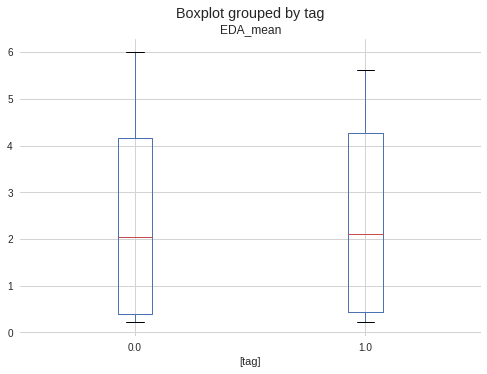

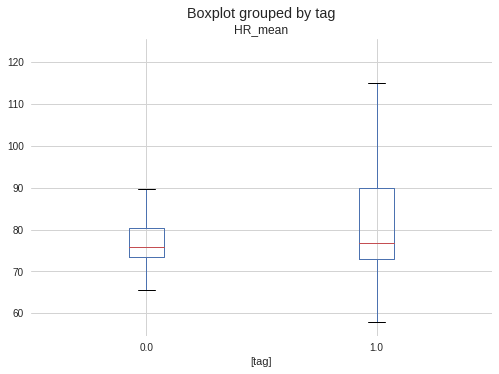

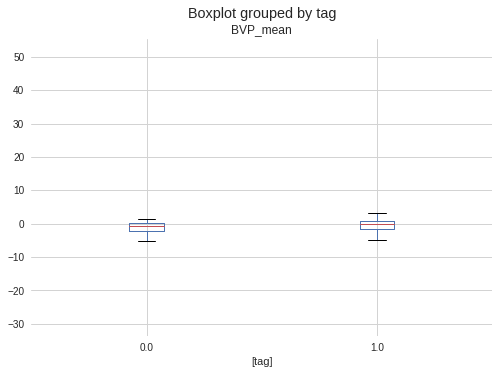

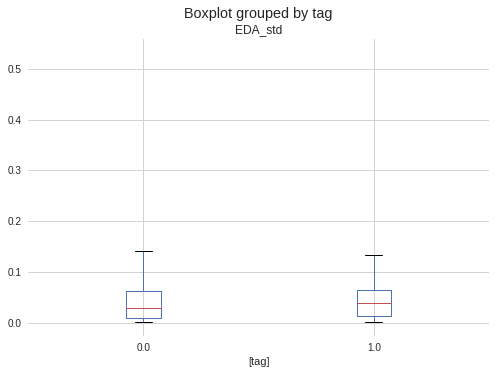

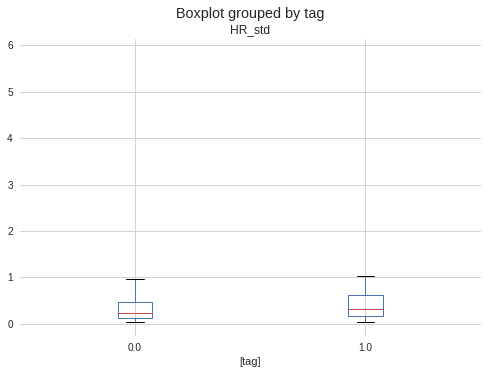

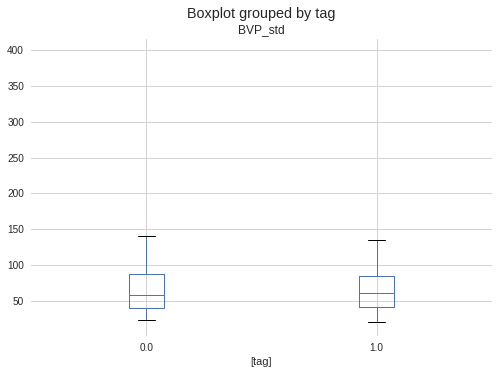

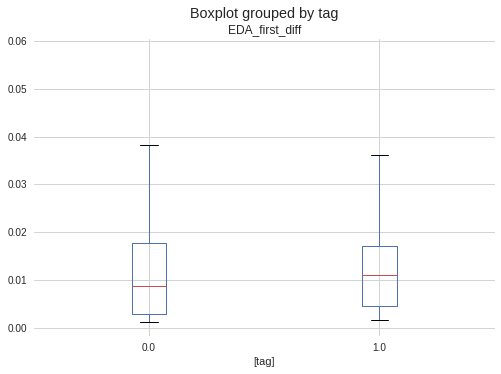

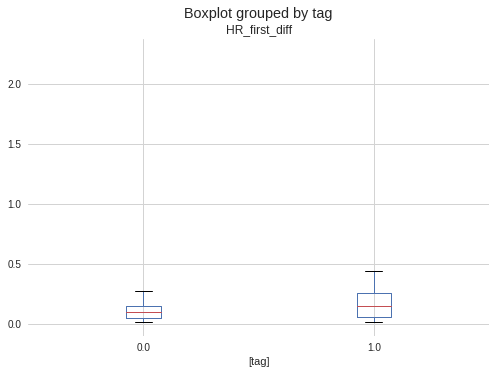

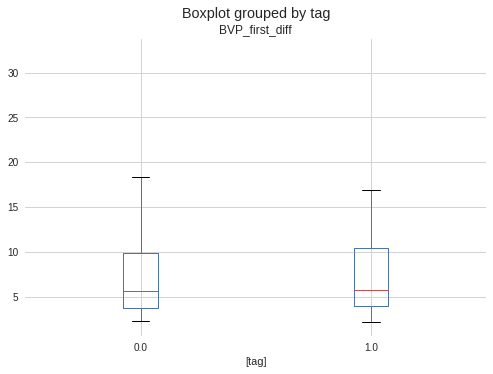

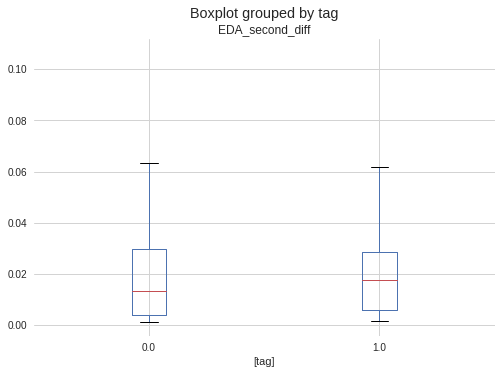

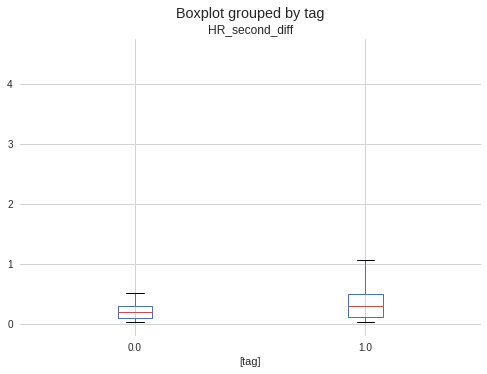

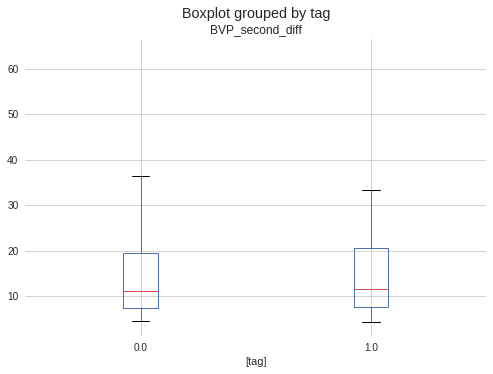

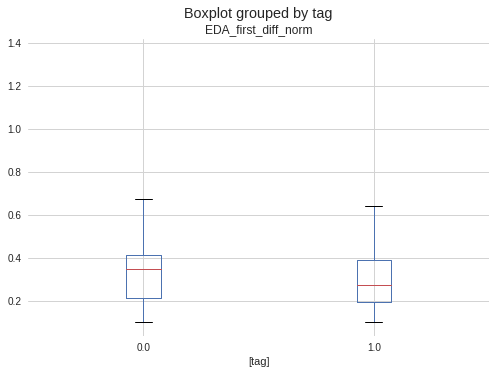

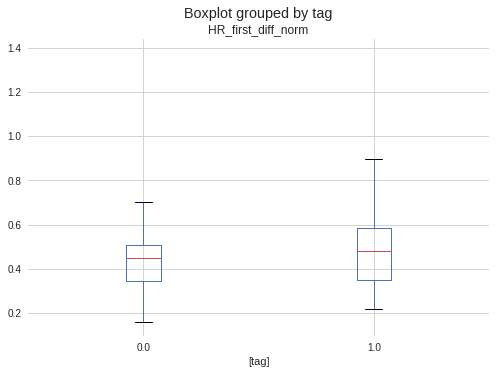

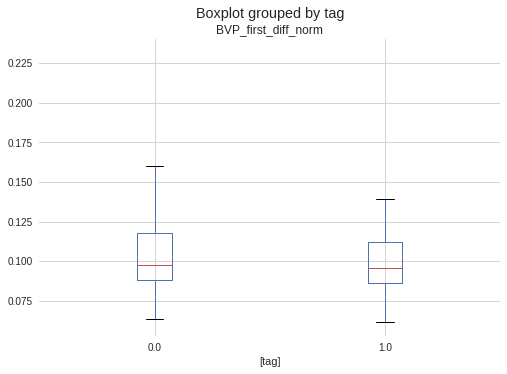

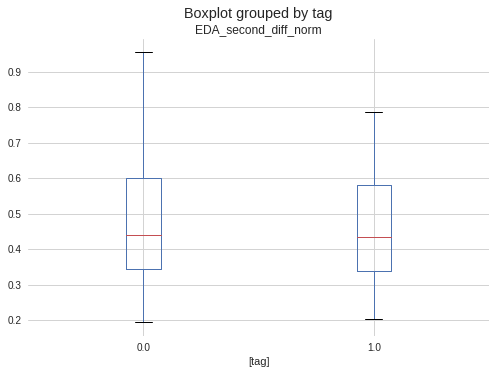

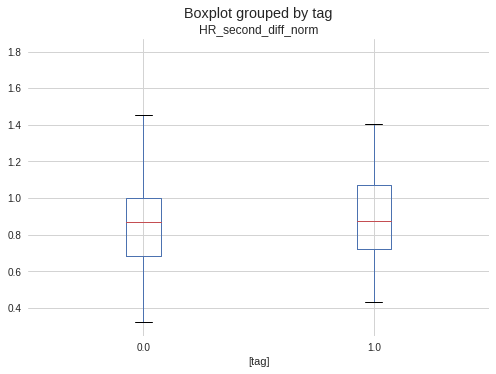

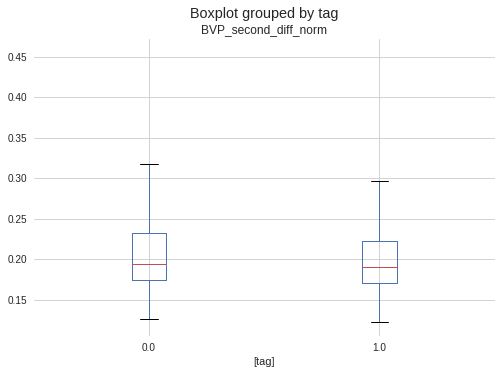

In [0]:
#----------------------------------------------------------------------------#
# Box-plots for initial exploratory analysis
#----------------------------------------------------------------------------#

stats = ['mean', 'std', 'first_diff', 'second_diff', 'first_diff_norm', 'second_diff_norm']
signals = ['EDA_', 'temp_', 'HR_', 'BVP_']

for col in stats:
  
    agg_eda[['tag', signals[0] + col]].boxplot(by = "tag")
    agg_hr[['tag', signals[2] + col]].boxplot(by = "tag")
    agg_bvp[['tag', signals[3] + col]].boxplot(by = "tag")


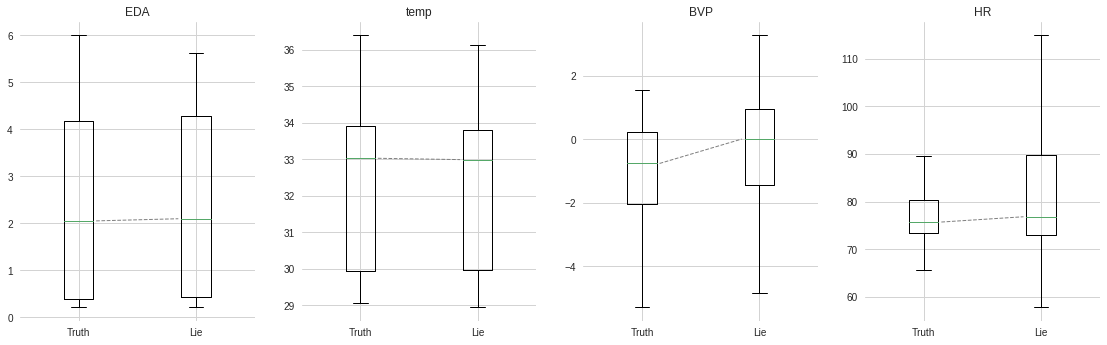

In [0]:
# Boxplot of the means for the report
to_plot = merge_data[['tag', "EDA_mean", "temp_mean", "BVP_mean", "HR_mean"]]

for i, stat in enumerate(["EDA_mean", "temp_mean", "BVP_mean", "HR_mean"]):
    
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['grid.color'] = "lightgrey"
    plt.subplots_adjust(left=None, bottom=None, right=2, top=None, wspace=None, hspace=None)
    plt.subplot(1,4, i+1)
     
    truth = to_plot[stat][to_plot["tag"] == 0]
    lie = to_plot[stat][to_plot["tag"] == 1]
    
    m_truth = np.median(truth)
    m_lie = np.median(lie)

    data = [truth, lie]

    plt.boxplot(data, positions = [0, 1], showfliers=False, widths = 0.25)
    plt.plot([0.15,0.85], [m_truth, m_lie], "--", color = "grey", linewidth=1)
    plt.xticks([0,1], ["Truth", "Lie"])
    plt.title(stat.replace("_mean", "")) 

plt.show()

### Logistic residual plots


In [0]:
lo = 5
merge_data_noval = merge_data[merge_data["p_id"] != lo]

X_train = merge_data_noval
X_train = X_train.drop(columns=["tag"])
y_train = merge_data_noval["tag"]

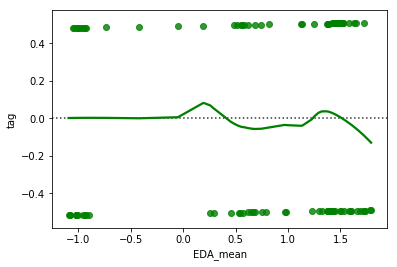

In [28]:
sns.residplot(X_train['EDA_mean'], y_train, lowess=True, color="g")

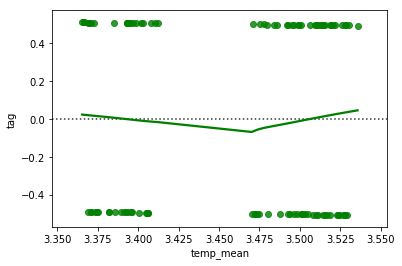

In [29]:
sns.residplot(X_train['temp_mean'], y_train, lowess=True, color="g")

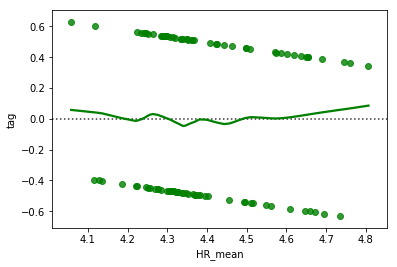

In [30]:
sns.residplot(X_train['HR_mean'], y_train, lowess=True, color="g")

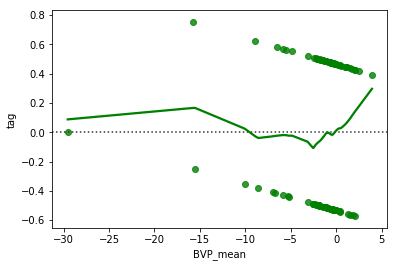

In [31]:
sns.residplot(X_train['BVP_mean'], y_train, lowess=True, color="g")

## Explore different combinations of responses

Potential questions:

*   Do signals depend on time as well as whether they are a truth or lie?
*   How do individual participants compare grouped by truths and lies?



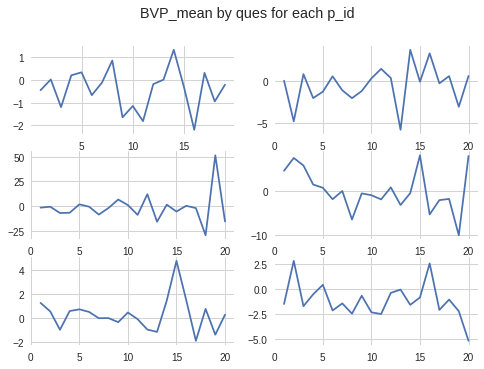

In [0]:

stat = 'BVP_mean' #@param ['EDA_mean', 'EDA_std', 'EDA_first_diff','EDA_second_diff', 'EDA_first_diff_norm', 'EDA_first_diff_norm', 'EDA_second_diff_norm', 'temp_mean', 'temp_std', 'temp_first_diff', 'temp_second_diff', 'temp_first_diff_norm', 'temp_second_diff_norm', 'HR_mean', 'HR_std', 'HR_first_diff', 'HR_second_diff', 'HR_first_diff_norm', 'HR_second_diff_norm', 'BVP_mean', 'BVP_std', 'BVP_first_diff', 'BVP_second_diff', 'BVP_first_diff_norm', 'BVP_second_diff_norm']
x_axis = "ques" #@param ['ques', 'tag', 'p_id']
facet = "p_id" #@param ['p_id', 'tag']

# Pre-define the number of subplots needed
if facet == "p_id":  
  num = 6  
else:
  num = 2

# For each subplot create the image based on the options selected
for i in range(num):
    
    # Create full feature list
    features = [stat, x_axis]
    
    # Select the correct columns
    temp = merge_data[features][merge_data[facet] == i].sort_values(x_axis)
    
    # Identify the position of the subplot being plotted 
    if facet == "p_id":
      plt.subplot(3,2, i+1)
    else:
      plt.subplot(2,1, i+1)
      
    # Run plot
    if x_axis == "ques":
    
      plt.plot(temp[x_axis],temp[stat])
      
    elif  x_axis == "tag":
      
      truth = temp[stat][temp[x_axis] == 0]
      lie = temp[stat][temp[x_axis] == 1]
      
      data = [truth, lie]
      
      plt.boxplot(data, positions = [0, 1])
      
    else:
      
      p0 = temp[stat][temp[x_axis] == 0]
      p1 = temp[stat][temp[x_axis] == 1]
      p2 = temp[stat][temp[x_axis] == 2]
      p3 = temp[stat][temp[x_axis] == 3]
      p4 = temp[stat][temp[x_axis] == 4]
      p5 = temp[stat][temp[x_axis] == 5]  
      
      data = [p0, p1, p2, p3, p4, p5]
      
      plt.boxplot(data, positions = [0, 1, 2, 3, 4, 5])
      
# Add the title and output
plt.suptitle(stat + " by " + x_axis + " for each " + facet)
plt.show()

## t-SNE

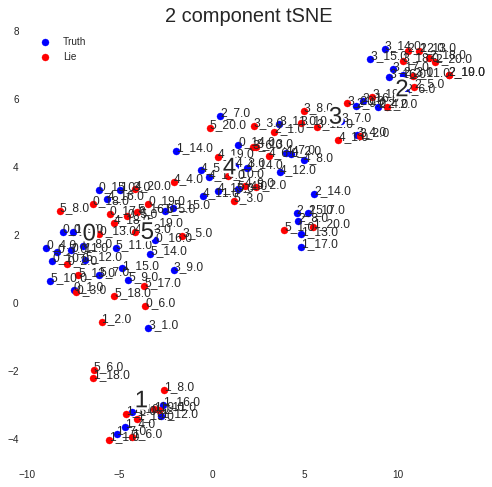

In [0]:
from sklearn.manifold import TSNE
import matplotlib.patheffects as PathEffects

perplexity = 30 #@param
learning_rate = 200 #@param
# Get the data in one format
X_all = merge_data.loc[:,'EDA_mean':]
indices = ["_".join([str(merge_data.loc[i, 'p_id']),str(merge_data.loc[i, 'ques'])])  for i in range(len(merge_data))]
y_all = pd.concat([y_train,y_test])

X_tsne = TSNE(learning_rate=learning_rate,
              perplexity=perplexity).fit_transform(X_all)
final_df = pd.concat([pd.DataFrame(X_tsne, columns=['Dimension 1','Dimension 2']),
                      y_all.reset_index()], axis=1)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_title('2 component tSNE', fontsize = 20)
targets = [0,1]
colors = ['b', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = (final_df["tag"] == target)
    ax.scatter(final_df.loc[indicesToKeep, 'Dimension 1'],
               final_df.loc[indicesToKeep, 'Dimension 2'],
               c = color, s = 50)
# Annotate each point
for i, txt in enumerate(indices):
  ax.annotate(txt, (final_df.loc[:, 'Dimension 1'][i],
                    final_df.loc[:, 'Dimension 2'][i]))
  
# Adds label to the centre of the data points for each person
NUM_PERSONS = 6 
for i in range(NUM_PERSONS):
  # Position of each label at median of data points.
  xtext, ytext = np.median(final_df[['Dimension 1','Dimension 2']]
                           [merge_data.loc[:, 'p_id'] == i],
                           axis=0)
  txt = ax.text(xtext, ytext, str(i), fontsize=24)
  txt.set_path_effects([
      PathEffects.Stroke(linewidth=5, foreground="w"),
      PathEffects.Normal()])
ax.legend(["Truth","Lie"])
ax.grid()  

In [0]:
# t-SNE plots for the group report
perplexity = 30 #@param
learning_rate = 200 #@param

# Get the data in one format
X_all = merge_data.loc[:,'EDA_mean':]
indices = ["_".join([str(merge_data.loc[i, 'p_id']),str(merge_data.loc[i, 'ques'])])  for i in range(len(merge_data))]
y_all = merge_data.loc[:, ["p_id", "tag"]]

X_tsne = TSNE(learning_rate=learning_rate,
              perplexity=perplexity).fit_transform(X_all)
final_df = pd.concat([pd.DataFrame(X_tsne, columns=['Dimension 1','Dimension 2']),
                      y_all.reset_index()], axis=1)


fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

# Plot the dimensions colouring by participant
ax.set_title('2 component tSNE coloured by participant', fontsize = 20)
targets = np.arange(0,6)
colors = ['b', 'r', 'g', 'orange', 'c', 'k']
for target, color in zip(targets,colors):
    indicesToKeep = (final_df["p_id"] == target)
    ax.scatter(final_df.loc[indicesToKeep, 'Dimension 1'],
               final_df.loc[indicesToKeep, 'Dimension 2'],
               c = color, s = 50)

# Plot the dimensions colouring by participant
ax2.set_title('2 component tSNE coloured by label', fontsize = 20)
targets = [0, 1]
colors = ['b', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = (final_df["tag"] == target)
    ax2.scatter(final_df.loc[indicesToKeep, 'Dimension 1'],
               final_df.loc[indicesToKeep, 'Dimension 2'],
               c = color, s = 50)
ax2.legend(["Truth","Lie"])
fig.show()

# Initial models to try out as discussed in the group report

In [0]:
#----------------------------------------------------------------------------#
# Model Function - almost identical to the one used for OpenFace with an additional
# section to plot the importance features when there are less than 20 features.
#----------------------------------------------------------------------------#

def run_models(X_train,y_train,X_test,y_test, verbose=True, save_preds=False):
  '''A nice helper function for running loads of preset models'''
  model_options = [{'name':'Logistic Regression','model': LogisticRegression()},
                   {'name':'Support Vector Machine (SVM)','model': SVC(probability=True)},
                   {'name':'K Nearest Neighbours (KNN)','model': KNeighborsClassifier()},
                   {'name':'Decision Tree','model': DecisionTreeClassifier()},
                   {'name':'Random Forest','model': RandomForestClassifier(n_estimators=100)},
                   {'name':'Gradient Boosting','model': GradientBoostingClassifier(n_estimators=50)}]  
  N_MODELS = len(model_options)   

  # Create the results dataframe
  results_df = pd.DataFrame()
  num_DP = 3 # Number of decimal places to round numbers in the results to
  for model_num in range(N_MODELS):
    model_dict = model_options[model_num]
    model = model_dict['model']
    model_name = model_dict['name']
    print('------------------ Training Model:',model_name,'------------------')
    model.fit(X_train,y_train)
    y_preds = model.predict(X_test)
    y_probs = model.predict_proba(X_test)

    # Plot feature importances
    if model_name in ['Random Forest', 'Gradient Boosting']:
      importances = model.feature_importances_
      std = np.std([tree[0].feature_importances_ for tree in model.estimators_],
               axis=0)
      indices = np.argsort(importances)[::-1]
      
      std = np.std([model.feature_importances_ ])
      indices = np.argsort(importances)[::-1]
      
      # Select the number of importances to display
      if len(importances) < 20
        n = int(np.ceil(len(importances)/2))
      else:
        n = 10

      # Plot the feature importances of the forest
      fig, axes = plt.subplots(nrows=1, ncols=2)
      axes[0].set_title("Top " + str(n) + " Feature Importances")
      axes[1].set_title("Bottom " + str(n) + " Feature Importances")
      axes[0].bar(range(n), importances[indices[:n]],color="r", 
                  yerr=std[indices[:n]], align="center")
      axes[1].bar(range(n), importances[indices[-n:]],color="r", 
                  yerr=std[indices[-n:]], align="center")
      axes[0].set_xticklabels(X_train.iloc[:,indices[:n+1]].columns.tolist())
      axes[1].set_xticklabels(X_train.iloc[:,indices[-(n+1):]].columns.tolist())
      for ax in axes:
        # Rotate the xticks on each axis
        plt.sca(ax)
        plt.xticks(rotation=90)
      plt.show() 

    # Get confusion matrix, FPRs, TPRs etc  
    confusion_matrix = metrics.confusion_matrix(y_test, y_preds) 
    FPRs, TPRs, thresholds = metrics.roc_curve(y_test, y_probs[:,1])
    roc_auc = metrics.auc(FPRs, TPRs)
    
    # Plot confusion matrix and ROC curves
    plt.figure()
    fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(13,3))
    
    sns.heatmap(confusion_matrix, annot=True, ax = axes[0], fmt='g')
    axes[0].set_xlabel('Predicted labels'); axes[0].set_ylabel('True labels') 
    axes[0].set_title('Confusion Matrix')
    
    axes[1].set_title('Receiver Operating Characteristic')
    axes[1].plot(FPRs, TPRs, 'b', label = 'AUC = %0.2f' % roc_auc)
    axes[1].legend(loc = 'lower right')
    axes[1].plot([0, 1], [0, 1],'r--')
    axes[1].set_xlim([0, 1]); axes[1].set_ylim([0, 1])
    axes[1].set_ylabel('True Positive Rate (TPR)')
    axes[1].set_xlabel('False Positive Rate (FPR)')

    plt.show()

    # Calculate the results dataframe with key metrics
    results_df = results_df.append({'Model Name': model_name,
                                    'Accuracy': round(metrics.accuracy_score(y_test,y_preds),num_DP),
                                    'Precision': round(metrics.precision_score(y_test,y_preds),num_DP),
                                    'Recall': round(metrics.recall_score(y_test,y_preds),num_DP),
                                    'F1 Score': round(metrics.f1_score(y_test,y_preds),num_DP),
                                    'AUC': round(roc_auc,num_DP),
                                    'FNR': round(confusion_matrix[1,0]/np.sum(confusion_matrix[:,0]) ,num_DP),
                                    'FPR': round(confusion_matrix[0,1]/np.sum(confusion_matrix[:,1]) ,num_DP)
                                   },
                                   ignore_index=True)

  results_df.set_index('Model Name', inplace=True)
  return results_df





------------------ Training Model: Gradient Boosting ------------------


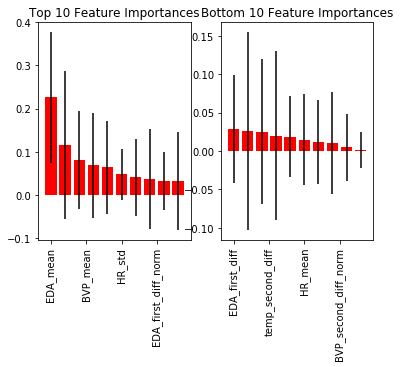

<Figure size 432x288 with 0 Axes>

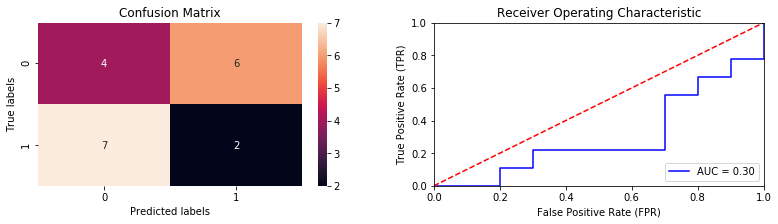

,AUC,Accuracy,F1 Score,FNR,FPR,Precision,Recall
Model Name,,,,,,,
Gradient Boosting,0.3,0.316,0.235,0.636,0.75,0.25,0.222


In [0]:
# Id of the person to leave out
loo = 5

# Create the train and test sets
X_train = merge_data.loc[:,'EDA_mean':][merge_data["p_id"] != loo]
y_train = merge_data["tag"][merge_data["p_id"] != loo]

X_test = merge_data.loc[:,'EDA_mean':][merge_data["p_id"] == loo]
y_test = merge_data["tag"][merge_data["p_id"] == loo]

# Run the model function and output results
results_df = run_models(X_train,y_train,X_test,y_test)
results_df

------------------ Training Model: Gradient Boosting ------------------


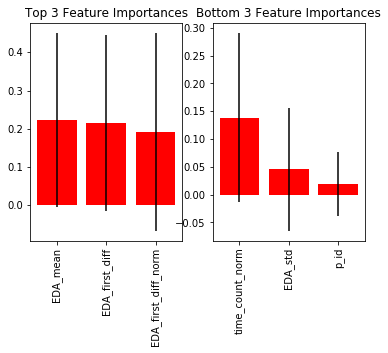

<Figure size 432x288 with 0 Axes>

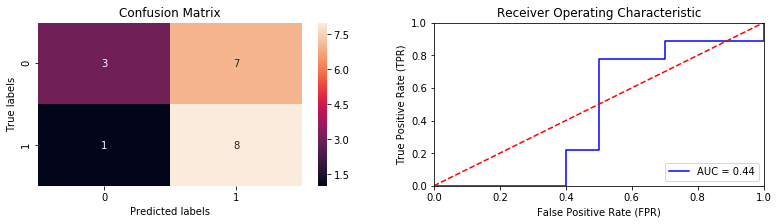

,AUC,Accuracy,F1 Score,FNR,FPR,Precision,Recall
Model Name,,,,,,,
Gradient Boosting,0.444,0.579,0.667,0.25,0.467,0.533,0.889


In [0]:
lo = 5
X_train = merge_data[["p_id","EDA_mean", "EDA_std", "EDA_first_diff", "EDA_second_diff", "EDA_first_diff_norm", "time_count_norm"]][merge_data["p_id"] != lo]
y_train = merge_data["tag"][merge_data["p_id"] != lo]


X_test = merge_data[["p_id", "EDA_mean", "EDA_std", "EDA_first_diff", "EDA_second_diff", "EDA_first_diff_norm", "time_count_norm"]][merge_data["p_id"] == lo]
y_test = merge_data["tag"][merge_data["p_id"] == lo]

results_df = run_models(X_train,y_train,X_test,y_test)
results_df

# Feature selection

The code below goes through each setting of normalisation and combination fo EDA, BVP, HR and temperature. Time is always included.

In [0]:
lo = 5
merge_data_noval = merge_data[merge_data["p_id"] != lo]

In [0]:
# Set the normalisation strategy (None) and the list to indicate whether to 
# take the log or not.
norm_strat = [0]
take_log = [True, False]

# Create the final results dataframe
hyper_results_df = pd.DataFrame(columns = ['Model Name','Accuracy', 'Precision','Recall','F1 Score', "AUC", 
                                           
                                           "FNR", "FPR", "norm", "log", "comb", "person_id"])

for n_strat in norm_strat:
    
    for t_log in take_log:

        # Data normalisation strategy
        # 0 - none
        # 1 - standardise over whole interaction (x-mean)/std
        # 2 - normalise (feature scale) over whole interaction (x-min)/(max-min)
        # 3 - take off mean from pre-experiment
        n_strat = n_strat
        # These settings remove smoothinga as a feature
        # Number of seconds to smooth over
        s_frame = 0
        # Polynomial approx for each window
        s_poly = 2
        
        #---------------------------------------------------------------------#
        # Generate data 
        #---------------------------------------------------------------------#
        eda_data = create_signal_data(data_files, "EDA", normalise = n_strat, 
                                      smoothing_frame = s_frame, smoothing_poly = s_poly)
        temp_data = create_signal_data(data_files, "temp", normalise = n_strat,  
                                       smoothing_frame = s_frame, smoothing_poly = s_poly)
        hr_data = create_signal_data(data_files, "HR", normalise = n_strat,  
                                     smoothing_frame = s_frame, smoothing_poly = s_poly)
        bvp_data = create_signal_data(data_files, "BVP", normalise = n_strat,  
                                      smoothing_frame = s_frame, smoothing_poly = s_poly)
        
        # Use the smooth data - if available - to produces the stats?
        # Will always produce the smoothed mean
        use_smooth = False
        
        group = ["tag", "ques", "p_id"]
        
        agg_eda = generate_simple_stats(eda_data, "EDA", group = group, smoothed = use_smooth)
        agg_temp = generate_simple_stats(temp_data, "temp", group = group, smoothed = use_smooth)
        agg_hr = generate_simple_stats(hr_data, "HR", group = group, smoothed = use_smooth)
        agg_bvp = generate_simple_stats(bvp_data, "BVP", group = group, smoothed = use_smooth)
    
        # How long are the interactions?
        time_per_interaction = eda_data.groupby(["tag", "ques", "p_id"]).agg({"time": [np.ma.count]}).reset_index()
        time_per_interaction.columns = ["tag", "ques", "p_id", "time_count"]
        time_per_interaction["time_count"] = time_per_interaction["time_count"]/4
        time_per_interaction["time_count_norm"] = (time_per_interaction["time_count"] - 
                            np.mean(time_per_interaction["time_count"]))/np.std(time_per_interaction["time_count"])
        
        # Merge the aggregated data together
        merge_data = pd.merge(agg_eda, agg_temp, how='left', on=['tag', 'ques', 'p_id'])
        merge_data = pd.merge(merge_data, agg_hr, how='left', on=['tag', 'ques', 'p_id'])
        merge_data = pd.merge(merge_data, agg_bvp, how='left', on=['tag', 'ques', 'p_id'])
        # Take normalised time as performs better
        merge_data = pd.merge(merge_data, time_per_interaction.drop(columns =["time_count"]), how='left', on=['tag', 'ques', 'p_id'])

        # Remove test participant
        lo = 5
        merge_data_noval = merge_data[merge_data["p_id"] != lo]
       
        
        if t_log:
        
            # Takes the log of the features
            merge_data_noval.loc[:,'EDA_mean':] = ma.log(np.array(merge_data_noval.loc[:,'EDA_mean':]))
        
        #----------------------------------------------------------------------#
        # Test all combinations of features for the data setting
        #----------------------------------------------------------------------#
        
        feature_sets = ["EDA", "temp", "HR", "BVP"]
        
        # Extract the column names
        column_eda = [col for col in merge_data_noval.columns.values if "EDA" in col]
        column_temp = [col for col in merge_data_noval.columns.values if "temp" in col]
        column_hr = [col for col in merge_data_noval.columns.values if "HR" in col]
        column_bvp = [col for col in merge_data_noval.columns.values if "BVP" in col]
        
        for eda in [0, 1]:
            
            for temp in [0,1]:
                
                for hr in [0, 1]:
                    
                    for bvp in [0, 1]:
                        
                        for loo in range(5):
                          
                            # Select columns of features to test
                            columns = column_eda*eda + column_temp*temp + column_hr*hr + column_bvp*bvp + ["time_count_norm"]
                          
                            print("------------ Time + " + "E"*eda + "T"*temp + "H"*hr + "B"*bvp + str(loo/5))
                                               
                            if len(columns) > 0:
                
                                # Create the train and test sets
                                X_train = merge_data_noval.loc[:,columns][merge_data_noval["p_id"] != loo]
                                y_train = merge_data_noval["tag"][merge_data_noval["p_id"] != loo]
                                
                                X_test = merge_data_noval.loc[:,columns][merge_data_noval["p_id"] == loo]
                                y_test = merge_data_noval["tag"][merge_data_noval["p_id"] == loo]
                                   
                                # Run the model function
                                results_df = run_models(X_train,y_train,X_test,y_test)
                                  
                                # Add additional information about run to dataframe
                                results_df["norm"] = n_strat
                                results_df["log"] = t_log
                                results_df["comb"] = "Time + " + "E"*eda + "T"*temp + "H"*hr + "B"*bvp
                                results_df["person_id"] = loo
                                
                                # Add to final dataframe
                                hyper_results_df = pd.concat([hyper_results_df,results_df])

# Re-index
hyper_results_df = hyper_results_df.reset_index()


In [0]:
# Collate the results from the cross validation and rename the columns
hyper_results_collated = hyper_results_df.groupby(["comb", "index", "norm", "log"]).agg({"Accuracy": [np.max, np.mean, np.std],
                                                                "AUC": [np.max, np.mean, np.std]}).reset_index()

hyper_results_collated.columns = ["comb", "model", "norm", "log", "acc_max", "acc_mean", "acc_std", "auc_max", "auc_mean", "auc_std"]

In [0]:
hyper_results_collated.sort_values("auc_mean", ascending = False)

,comb,model,norm,log,acc_max,acc_mean,acc_std,auc_max,auc_mean,auc_std
27,Time + E,Gradient Boosting,0,True,0.700,0.5748,0.097083,0.730,0.6404,0.125023
33,Time + E,Random Forest,0,True,0.700,0.5958,0.079613,0.740,0.6400,0.091447
113,Time + ETHB,K Nearest Neighbours (KNN),0,True,0.750,0.6064,0.137676,0.785,0.6232,0.142034
91,Time + ETB,Logistic Regression,0,True,0.650,0.5858,0.041632,0.740,0.6168,0.079882
51,Time + EH,Gradient Boosting,0,True,0.700,0.5332,0.137700,0.830,0.6160,0.155660
98,Time + ETH,Gradient Boosting,0,False,0.800,0.5536,0.175399,0.820,0.6158,0.174766
104,Time + ETH,Random Forest,0,False,0.650,0.5136,0.166957,0.840,0.6132,0.184509
19,Time + B,Logistic Regression,0,True,0.650,0.5564,0.077491,0.710,0.6120,0.093648
110,Time + ETHB,Gradient Boosting,0,False,0.650,0.5448,0.097648,0.770,0.6106,0.148599
32,Time + E,Random Forest,0,False,0.650,0.5652,0.048530,0.720,0.6094,0.120486


# Parameter search

After having found the best model, we conduct parameter search for the top 5 model. 
The result is a table, where 
* column 1: accuracy
* column 2: precision
* column 3: recall
* column 4: AUC (our metric of choice)

### Gradient Boosting

using only Using only log transformation of EDA

In [0]:
results = []

#columns = ["p_id", "tag", "EDA_mean", "EDA_std", "EDA_first_diff", "EDA_second_diff", "EDA_first_diff_norm", "time_count_norm"]
#merge_data_noval = merge_data_noval.reindex(columns=columns)
#p[columns] = p[columns].astype(int)

merge_data_noval = merge_data_noval[["tag", "p_id", "EDA_mean", "EDA_std", "EDA_first_diff", "EDA_second_diff", "EDA_first_diff_norm", "time_count_norm"]]
for _ in range(0, 5):
  for k in [10, 50, 100, 150, 200]:
    for loo in range(5):
      model_boost = GradientBoostingClassifier(n_estimators=k)

      X_train = merge_data_noval[["EDA_mean", "EDA_std", "EDA_first_diff", "EDA_second_diff", "EDA_first_diff_norm", "time_count_norm"]][merge_data_noval["p_id"] != loo]
      y_train = merge_data_noval["tag"][merge_data_noval["p_id"] != loo]

      X_test = merge_data_noval[["EDA_mean", "EDA_std", "EDA_first_diff", "EDA_second_diff", "EDA_first_diff_norm", "time_count_norm"]][merge_data_noval["p_id"] == loo]
      y_test = merge_data_noval["tag"][merge_data_noval["p_id"] == loo]

      model_boost.fit(X_train, y_train)
      y_preds = model_boost.predict(X_test)
      y_probs = model_boost.predict_proba(X_test)

      # ROC 
      FPRs, TPRs, thresholds = metrics.roc_curve(y_test, y_probs[:,1])
      roc_auc = metrics.auc(FPRs, TPRs)

      results.append([k, metrics.accuracy_score(y_test,y_preds), metrics.precision_score(y_test,y_preds), 
                      metrics.recall_score(y_test,y_preds), roc_auc])

results = pd.DataFrame(results)
results.groupby([0]).mean()

,1,2,3,4
0,,,,
10,0.478,0.491440,0.624,0.4972
50,0.476,0.491654,0.580,0.5572
100,0.482,0.496806,0.584,0.5252
150,0.514,0.533133,0.604,0.5192
200,0.482,0.511220,0.564,0.5116


### Random forest parameter search

Using only log transformation of EDA

In [0]:
results = []

#columns = ["p_id", "tag", "EDA_mean", "EDA_std", "EDA_first_diff", "EDA_second_diff", "EDA_first_diff_norm", "time_count_norm"]
#merge_data_noval = merge_data_noval.reindex(columns=columns)
#p[columns] = p[columns].astype(int)

merge_data_noval = merge_data_noval[["tag", "p_id", "EDA_mean", "EDA_std", "EDA_first_diff", "EDA_second_diff", "EDA_first_diff_norm", "time_count_norm"]]
for _ in range(0, 5):
  for k in [10, 50, 100, 150, 200]:
    for loo in range(5):
      model = RandomForestClassifier(n_estimators=k)

      X_train = merge_data_noval[["EDA_mean", "EDA_std", "EDA_first_diff", "EDA_second_diff", "EDA_first_diff_norm", "time_count_norm"]][merge_data_noval["p_id"] != loo]
      y_train = merge_data_noval["tag"][merge_data_noval["p_id"] != loo]

      X_test = merge_data_noval[["EDA_mean", "EDA_std", "EDA_first_diff", "EDA_second_diff", "EDA_first_diff_norm", "time_count_norm"]][merge_data_noval["p_id"] == loo]
      y_test = merge_data_noval["tag"][merge_data_noval["p_id"] == loo]

      model.fit(X_train, y_train)
      y_preds = model.predict(X_test)
      y_probs = model.predict_proba(X_test)
      #print(y_probs)

      # ROC 
      FPRs, TPRs, thresholds = metrics.roc_curve(y_test, y_probs[:,1])
      roc_auc = metrics.auc(FPRs, TPRs)

      results.append([k, metrics.accuracy_score(y_test,y_preds), metrics.precision_score(y_test,y_preds), 
                      metrics.recall_score(y_test,y_preds), roc_auc])

results = pd.DataFrame(results)
results.groupby([0]).mean()

,1,2,3,4
0,,,,
10,0.516,0.501575,0.444,0.5292
50,0.500,0.512611,0.496,0.5016
100,0.496,0.511446,0.528,0.5140
150,0.506,0.520563,0.536,0.5174
200,0.502,0.513828,0.540,0.5130


###  K-nn parameter search

Using log transformation of all features 

In [0]:
results = []

for _ in range(0, 5):
  for k in range(1, 10):
    for loo in range(5):
      model = KNeighborsClassifier(n_neighbors=k)
      

      X_train = merge_data[merge_data["p_id"] != loo]
      X_train = X_train.drop(columns=["tag"])
      y_train = merge_data["tag"][merge_data["p_id"] != loo]

      X_test = merge_data.loc[merge_data["p_id"] == loo]
      X_test = X_test.drop(columns=["tag"])
      y_test = merge_data["tag"][merge_data["p_id"] == loo]

      model.fit(X_train, y_train)
      y_preds = model.predict(X_test)
      y_probs = model.predict_proba(X_test)

      # ROC 
      FPRs, TPRs, thresholds = metrics.roc_curve(y_test, y_probs[:,1])
      roc_auc = metrics.auc(FPRs, TPRs)

      results.append([k, metrics.accuracy_score(y_test,y_preds), metrics.precision_score(y_test,y_preds), 
                      metrics.recall_score(y_test,y_preds), roc_auc])

results = pd.DataFrame(results)
results.groupby([0]).mean()

,1,2,3,4
0,,,,
1,0.51,0.512266,0.48,0.510
2,0.53,0.470000,0.26,0.523
3,0.51,0.535714,0.46,0.497
4,0.46,0.456190,0.20,0.470
5,0.48,0.477020,0.42,0.485
6,0.45,0.443333,0.22,0.477
7,0.47,0.469553,0.38,0.466
8,0.47,0.460000,0.26,0.486
9,0.49,0.482692,0.46,0.502


### Predicted probabilities for the 3 models

In [0]:
X_val.head(5)

,p_id,EDA_mean,EDA_std,EDA_first_diff,EDA_second_diff,EDA_first_diff_norm,time_count_norm
1,5,-1.456090,-5.528242,-6.048517,-6.279342,-0.520275,1.534373
10,5,-1.515778,-6.435815,-6.326970,-6.842436,0.108845,-0.168658
19,5,-1.454992,-6.406705,-6.196542,-6.930405,0.210164,-0.764781
22,5,-1.439250,-6.599847,-6.294180,-6.786866,0.305667,-0.168658
26,5,-1.426076,-6.368061,-6.757753,-6.547636,-0.389692,-0.168658


In [0]:
#model1 = KNeighborsClassifier(n_neighbors=5)
#model2 = RandomForestClassifier(n_estimators=50)
model3 = GradientBoostingClassifier(n_estimators=50)
lo = 5

X_train = merge_data[["p_id","EDA_mean", "EDA_std", "EDA_first_diff", "EDA_second_diff", "EDA_first_diff_norm", "time_count_norm"]][merge_data["p_id"] != lo]
y_train = merge_data["tag"][merge_data["p_id"] != lo]


X_val = merge_data[["p_id", "EDA_mean", "EDA_std", "EDA_first_diff", "EDA_second_diff", "EDA_first_diff_norm", "time_count_norm"]][merge_data["p_id"] == lo]
#print(X_val.shape, y_val.shape)
y_val = merge_data["tag"][merge_data["p_id"] == lo]

#model1.fit(X_val, y_val)
#y_val_preds = model1.predict(X_val)
#y_val_probs_knn = model1.predict_proba(X_val)

# ROC 
#FPRs, TPRs, thresholds = metrics.roc_curve(y_val, y_val_probs_knn[:,1])
#roc_auc = metrics.auc(FPRs, TPRs)

#print([k, metrics.accuracy_score(y_test,y_preds), metrics.precision_score(y_test,y_preds),metrics.recall_score(y_test,y_preds), roc_auc], y_val_probs_knn)

#model2.fit(X_val, y_val)
#y_val_preds = model2.predict(X_val)
#y_val_probs_rf = model2.predict_proba(X_val)

# ROC 
#FPRs, TPRs, thresholds = metrics.roc_curve(y_val, y_val_probs_rf[:,1])
#roc_auc = metrics.auc(FPRs, TPRs)

#print([k, metrics.accuracy_score(y_test,y_preds), metrics.precision_score(y_test,y_preds),metrics.recall_score(y_test,y_preds), roc_auc], y_val_probs_rf)

model3.fit(X_train, y_train)
y_val_preds = model3.predict(X_val)
y_val_probs_boosting = model3.predict_proba(X_val)
#print(X_val[["p_id", "ques"]], y_val_probs_boosting)


# ROC 
FPRs, TPRs, thresholds = metrics.roc_curve(y_val, y_val_probs_boosting[:,1])
roc_auc = metrics.auc(FPRs, TPRs)

print([metrics.accuracy_score(y_val,y_val_preds), metrics.precision_score(y_val,y_val_preds), metrics.recall_score(y_val,y_val_preds), roc_auc], y_val_probs_boosting)

[0.5789473684210527, 0.5333333333333333, 0.8888888888888888, 0.5] [[0.03861165 0.96138835]
 [0.17227664 0.82772336]
 [0.21054489 0.78945511]
 [0.17227664 0.82772336]
 [0.17227664 0.82772336]
 [0.91175898 0.08824102]
 [0.29787498 0.70212502]
 [0.29684208 0.70315792]
 [0.62483894 0.37516106]
 [0.59975064 0.40024936]
 [0.1598899  0.8401101 ]
 [0.19637043 0.80362957]
 [0.28002649 0.71997351]
 [0.20638166 0.79361834]
 [0.20018837 0.79981163]
 [0.36721556 0.63278444]
 [0.28495568 0.71504432]
 [0.6210051  0.3789949 ]
 [0.45130408 0.54869592]]


In [0]:
# merging results into a dataframe

empty_df = pd.DataFrame(columns=["set_index", "0", "1"])
set_index = merge_data[["p_id", "ques"]][merge_data["p_id"] == lo]
empty_df["set_index"]=set_index["p_id"].astype(str)+'_'+set_index["ques"].astype(int).astype(str)
empty_df["0"] = y_val_probs_boosting[:,0]
empty_df["1"] = y_val_probs_boosting[:,1]
empty_df.to_csv(r'\Empatica_preds.csv')

In [0]:
empty_df

,set_index,0,1
1,5_1,0.038612,0.961388
10,5_4,0.172277,0.827723
19,5_7,0.210545,0.789455
22,5_8,0.172277,0.827723
26,5_9,0.172277,0.827723
29,5_10,0.911759,0.088241
33,5_11,0.297875,0.702125
37,5_12,0.296842,0.703158
45,5_16,0.624839,0.375161
52,5_18,0.599751,0.400249


# Export EDA and probabilities  as pickle for model fusion

In [0]:
only_EDA = merge_data[["ques", "p_id", "tag", "EDA_mean", "EDA_std", "EDA_first_diff", "EDA_second_diff", "EDA_first_diff_norm", "time_count_norm"]]

In [0]:
only_EDA.head(5)

,ques,p_id,tag,EDA_mean,EDA_std,EDA_first_diff,EDA_second_diff,EDA_first_diff_norm,time_count_norm
0,1.0,3,0.0,-1.076573,-4.899337,-5.948859,-5.548980,-1.049522,-0.672650
1,1.0,5,0.0,-1.456090,-5.528242,-6.048517,-6.279342,-0.520275,1.534373
2,2.0,4,0.0,0.540591,-3.148039,-4.268326,-4.250710,-1.120286,0.202255
3,3.0,0,0.0,1.717378,-1.446065,-3.261553,-2.761416,-1.815489,-0.672650
4,3.0,2,0.0,1.604142,-3.005482,-3.814139,-3.386100,-0.808656,-0.672650


In [0]:
import pickle
df_empatica_features = only_EDA.rename({'tag':'p_id'},
                                         axis='columns').set_index(merge_data['p_id']
                                                                   .astype(int).astype(str) 
                                                                   + "_" + 
                                                                   merge_data['ques']
                                                                   .astype(int).astype(str))
with open('/content/gdrive/My Drive/Affective Computing/Data/Empatica Data/df_empatica_features', 'wb') as file:
    pickle.dump(df_empatica_features, file, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
y_val_probs_knn[:,1]

y_val_probs_rf[:,1]

y_val_probs_boosting[:,1]

In [0]:
with open('/content/gdrive/My Drive/Affective Computing/Data/Empatica Data/boosting_probs.pickle', 'wb') as file:
    pickle.dump(y_val_probs_boosting[:,1], file, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
y_val_probs_boosting[:,1]

array([0.00325104, 0.00325104, 0.00325104, 0.00325104, 0.00325104,
       0.00325104, 0.00325104, 0.00325104, 0.00325104, 0.00325104,
       0.99674896, 0.99674896, 0.99674896, 0.99674896, 0.99674896,
       0.99674896, 0.99674896, 0.99674896, 0.99674896, 0.99674896])